In [2]:
import pandas as pd
df = pd.read_csv("datasets/reddit_cleaned.csv")

In [3]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Apply VADER to raw text column
df['vader_score'] = df['text'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

# Classify sentiment based on compound score
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['vader_score'].apply(classify_sentiment)

# Convert datetime and extract date for trend analysis
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['date'] = df['datetime'].dt.date

df.to_csv('datasets/reddit_with_sentiment.csv', index=False)
print("reddit_with_sentiment.csv")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/harrietmathew/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


reddit_with_sentiment.csv


In [12]:
# Classify strong sentiment
def classify_strong_sentiment(score):
    if score >= 0.6:
        return 'strong_positive'
    elif score <= -0.6:
        return 'strong_negative'
    else:
        return 'other'

df['platform'] = 'Reddit'
df['strong_sentiment'] = df['vader_score'].apply(classify_strong_sentiment)

# Group and summarize
grouped = df.groupby(['platform', 'event'])
summary = grouped.agg(
    avg_sentiment=('vader_score', 'mean'),
    total=('vader_score', 'count'),
    strong_positive=('strong_sentiment', lambda x: (x == 'strong_positive').sum()),
    strong_negative=('strong_sentiment', lambda x: (x == 'strong_negative').sum())
).reset_index()

# Add percentage columns
summary['% Strong Positive (≥ 0.6)'] = (summary['strong_positive'] / summary['total'] * 100).round(1)
summary['% Strong Negative (≤ -0.6)'] = (summary['strong_negative'] / summary['total'] * 100).round(1)

# Final summary table
summary_table = summary[['platform', 'event', 'avg_sentiment', '% Strong Positive (≥ 0.6)', '% Strong Negative (≤ -0.6)']]
summary_table.columns = ['Platform', 'Event', 'Avg. Sentiment', '% Strong Positive (≥ 0.6)', '% Strong Negative (≤ -0.6)']

# Save the summary table
summary_table.to_csv('datasets/reddit_emotional_unity_summary.csv', index=False)
print(summary_table)

  Platform      Event  Avg. Sentiment  % Strong Positive (≥ 0.6)  \
0   Reddit   Olympics        0.115646                       18.2   
1   Reddit  World Cup        0.083151                       15.8   

   % Strong Negative (≤ -0.6)  
0                         7.8  
1                         8.2  


In [14]:
reddit_summary = pd.read_csv('datasets/reddit_emotional_unity_summary.csv')
youtube_summary = pd.read_csv('datasets/youtube_emotional_unity_summary.csv')

combined_summary = pd.concat([reddit_summary, youtube_summary], ignore_index=True)
print(combined_summary)

  Platform      Event  Avg. Sentiment  % Strong Positive (≥ 0.6)  \
0   Reddit   Olympics        0.115646                       18.2   
1   Reddit  World Cup        0.083151                       15.8   
2  YouTube   Olympics        0.084994                       13.6   
3  YouTube  World Cup        0.085420                       10.6   

   % Strong Negative (≤ -0.6)  
0                         7.8  
1                         8.2  
2                         5.8  
3                         2.4  


In [16]:
from nrclex import NRCLex
from collections import Counter
import nltk
nltk.download('punkt')

# Function to extract emotion scores
def extract_emotions(text):
    if pd.isna(text) or not text.strip():
        return {}
    emotion = NRCLex(text)
    return emotion.raw_emotion_scores

# Apply to the cleaned text
df['emotion_scores'] = df['clean_text'].astype(str).apply(extract_emotions)
df.to_csv('datasets/reddit_with_emotions.csv', index=False)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/harrietmathew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
emotion_summary = {}

# Group by platform and event (e.g., Reddit - World Cup)
for (platform, event), group in df.groupby(['platform', 'event']):
    emotion_counter = Counter()
    for emotion_dict in group['emotion_scores']:
        emotion_counter.update(emotion_dict)
    
    total = sum(emotion_counter.values())
    proportions = {emotion: round((count / total) * 100, 2) for emotion, count in emotion_counter.items()}
    
    emotion_summary[(platform, event)] = proportions

# Convert to DataFrame
emotion_df = pd.DataFrame(emotion_summary).fillna(0).T.reset_index()
emotion_df.columns = ['Platform', 'Event'] + [col.capitalize() for col in emotion_df.columns[2:]]

# Save and print
emotion_df.to_csv('datasets/reddit_emotion_lexicon_breakdown.csv', index=False)
print(emotion_df)


  Platform      Event  Negative  Positive  Anticipation   Joy  Surprise  \
0   Reddit   Olympics     14.50     20.54         10.84  8.76      6.03   
1   Reddit  World Cup     15.63     17.94         11.30  8.18      5.65   

   Trust  Sadness  Anger  Disgust  Fear  
0  12.29     6.53   7.35     4.93  8.24  
1  12.43     7.21   8.10     5.20  8.38  


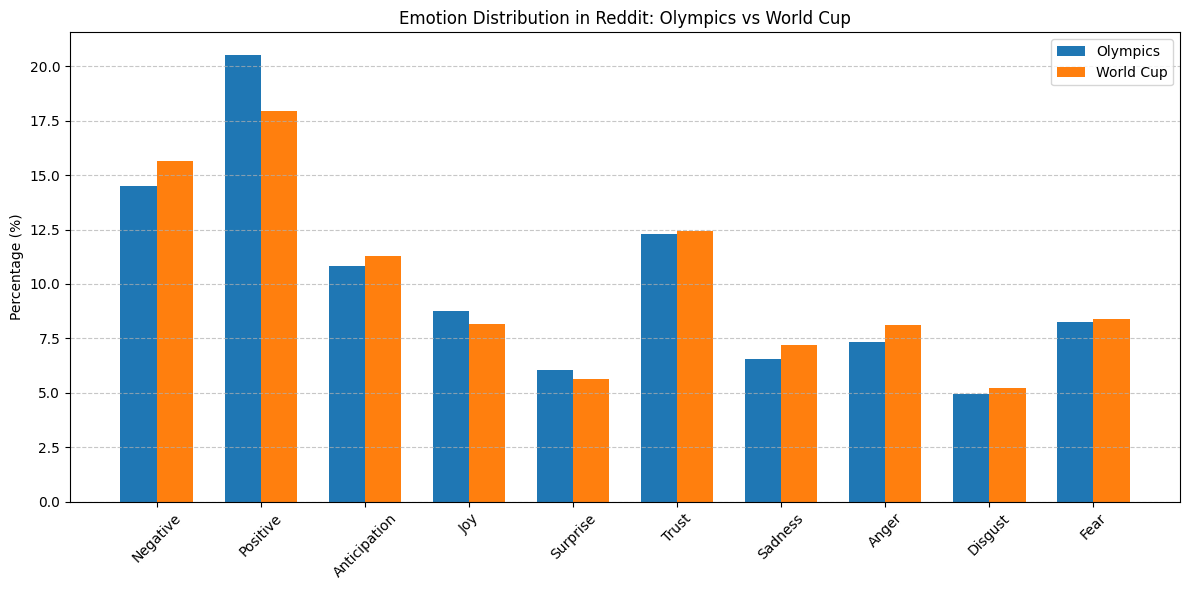

In [18]:
import matplotlib.pyplot as plt

# Filter for Reddit data only
reddit_df = emotion_df[emotion_df['Platform'] == 'Reddit']

# Select emotions to plot
emotion_cols = ['Negative', 'Positive', 'Anticipation', 'Joy', 'Surprise',
                'Trust', 'Sadness', 'Anger', 'Disgust', 'Fear']

# X-axis positions
x = range(len(emotion_cols))
bar_width = 0.35

# Get values for each event
olympics_vals = reddit_df[reddit_df['Event'] == 'Olympics'][emotion_cols].values.flatten()
worldcup_vals = reddit_df[reddit_df['Event'] == 'World Cup'][emotion_cols].values.flatten()

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar([p - bar_width/2 for p in x], olympics_vals, width=bar_width, label='Olympics')
bars2 = ax.bar([p + bar_width/2 for p in x], worldcup_vals, width=bar_width, label='World Cup')

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(emotion_cols, rotation=45)
ax.set_ylabel('Percentage (%)')
ax.set_title('Emotion Distribution in Reddit: Olympics vs World Cup')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [19]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load preprocessed dataset
df = pd.read_csv('datasets/reddit_with_sentiment.csv')

# Use already cleaned text for LDA
df['lda_text'] = df['clean_text']
df['strong_sentiment'] = df['vader_score'].apply(classify_strong_sentiment)

# LDA topic function
def get_topics_from_texts(texts, n_topics=4, n_top_words=10):
    # Drop NaN or empty strings before vectorization
    texts = texts.dropna()
    texts = texts[texts.str.strip() != '']
    
    vectorizer = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')
    X = vectorizer.fit_transform(texts)
    
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)

    words = vectorizer.get_feature_names_out()
    topic_keywords = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_keywords.append((f"Topic {topic_idx + 1}", top_words))
    return topic_keywords

    
for event in ['World Cup', 'Olympics']:
    for sentiment in ['strong_positive', 'strong_negative']:
        subset = df[(df['event'] == event) & (df['strong_sentiment'] == sentiment)]
        if not subset.empty:
            print(f"\nTop Topics in {sentiment.replace('_', ' ').title()} Comments - {event}")
            topics = get_topics_from_texts(subset['lda_text'])
            for topic, keywords in topics:
                print(f"{topic}: {', '.join(keywords)}")



Top Topics in Strong Positive Comments - World Cup
Topic 1: team, world, cup, win, best, like, year, final, game, time
Topic 2: good, game, year, win, play, happy, like, really, hope, time
Topic 3: player, team, like, game, best, win, play, great, england, think
Topic 4: like, people, world, qatar, country, love, cup, fifa, lol, dont

Top Topics in Strong Negative Comments - World Cup
Topic 1: team, player, dont, game, penalty, england, people, worst, shit, know
Topic 2: qatar, people, fifa, russia, country, world, dont, worker, way, make
Topic 3: like, time, player, game, really, team, thats, bad, good, goal
Topic 4: world, fuck, cup, shit, qatar, people, fucking, hell, country, like

Top Topics in Strong Positive Comments - Olympics
Topic 1: ceremony, paris, like, trump, olympics, amazing, great, project, beautiful, opening
Topic 2: people, dont, like, good, think, want, awesome, know, thats, trump
Topic 3: like, game, love, people, really, thing, good, make, think, time
Topic 4: me